## Fine-tune the Vision Transformer on CIFAR-10

## installing the relevant libraries.

In [1]:
!pip install -q transformers datasets pytorch-lightning

## Load the data

In [2]:
from datasets import load_dataset

# load cifar10 (only small portion for demonstration purposes) 
train_ds, test_ds = load_dataset('cifar10', split=['train[:5000]', 'test[:2000]'])
# split up training into training + validation
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

Found cached dataset cifar10 (/home/planck/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 4500
})

## features of the dataset in more detail:

In [4]:
train_ds.features

{'img': Image(decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

### each example has 2 features: 'img' (of type `Image`) and 'label' (of type `ClassLabel`). Check an example of the training dataset:

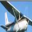

In [5]:
train_ds[0]['img']

In [6]:
train_ds[0]['label']

0

Indices and actual class names (id2label):

In [7]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [8]:
id2label[train_ds[0]['label']]

'airplane'

## Preprocessing the data

In [9]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]

For data augmentation, one can use any available library. Here we'll use torchvision's [transforms module](https://pytorch.org/vision/stable/transforms.html).

In [10]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

/home/planck/anaconda3/envs/bikash/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [11]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

We can now load preprocessed images (on-the-fly) as follows:

In [12]:
train_ds[:2]

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>],
 'label': [0, 3],
 'pixel_values': [tensor([[[-0.1216, -0.1216, -0.1216,  ..., -0.7882, -0.7882, -0.7882],
           [-0.1216, -0.1216, -0.1216,  ..., -0.7882, -0.7882, -0.7882],
           [-0.1216, -0.1216, -0.1216,  ..., -0.7882, -0.7882, -0.7882],
           ...,
           [-0.0510, -0.0510, -0.0510,  ...,  0.0431,  0.0431,  0.0431],
           [-0.0510, -0.0510, -0.0510,  ...,  0.0431,  0.0431,  0.0431],
           [-0.0510, -0.0510, -0.0510,  ...,  0.0431,  0.0431,  0.0431]],
  
          [[ 0.2392,  0.2392,  0.2392,  ..., -0.6235, -0.6235, -0.6235],
           [ 0.2392,  0.2392,  0.2392,  ..., -0.6235, -0.6235, -0.6235],
           [ 0.2392,  0.2392,  0.2392,  ..., -0.6235, -0.6235, -0.6235],
           ...,
           [ 0.4118,  0.4118,  0.4118,  ...,  0.4118,  0.4118,  0.4118],
           [ 0.4118,  0.4118,  0.4118,  ...,  0.4118,  0.4118,  0.

It's very easy to create corresponding PyTorch DataLoaders, like so:

In [13]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_batch_size = 2
eval_batch_size = 2

train_dataloader = DataLoader(train_ds, shuffle=True, collate_fn=collate_fn, batch_size=train_batch_size)
val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=eval_batch_size)
test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=eval_batch_size)

In [14]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([2, 3, 224, 224])
labels torch.Size([2])


In [15]:
assert batch['pixel_values'].shape == (train_batch_size, 3, 224, 224)
assert batch['labels'].shape == (train_batch_size,)

In [16]:
next(iter(val_dataloader))['pixel_values'].shape

torch.Size([2, 3, 224, 224])

## Define the model

In [17]:
import pytorch_lightning as pl
from transformers import ViTForImageClassification, AdamW
import torch.nn as nn

class ViTLightningModule(pl.LightningModule):
    def __init__(self, num_labels=10):
        super(ViTLightningModule, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                              num_labels=10,
                                                              id2label=id2label,
                                                              label2id=label2id)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits
        
    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        logits = self(pixel_values)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy
      
    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     

        return loss

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return AdamW(self.parameters(), lr=5e-5)

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

    def test_dataloader(self):
        return test_dataloader

## Train the model

initialize the model, and train it!

We also add a callback:
* early stopping (stop training once the validation loss stops improving after 3 times).

In [18]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

# for early stopping, see https://pytorch-lightning.readthedocs.io/en/1.0.0/early_stopping.html?highlight=early%20stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)

model = ViTLightningModule()
trainer = Trainer(accelerator="gpu", devices=1, callbacks=[EarlyStopping(monitor='validation_loss')])
trainer.fit(model)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used

Sanity Checking: 0it [00:00, ?it/s]

/home/planck/anaconda3/envs/bikash/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/planck/anaconda3/envs/bikash/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Finally, let's test the trained model on the test set:

In [19]:
trainer.test()

/home/planck/anaconda3/envs/bikash/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /DATA1/bikash_dutta/DAI/A2/lightning_logs/version_0/checkpoints/epoch=4-step=11250.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from t

Testing: 0it [00:00, ?it/s]

[{}]


## Adding data augmentaion and retrain the model

In [20]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize,
                                    TrivialAugmentWide,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            TrivialAugmentWide(num_magnitude_bins=2),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [21]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

We can now load preprocessed images (on-the-fly) as follows:

In [22]:
train_ds[:2]

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>],
 'label': [0, 3],
 'pixel_values': [tensor([[[-0.7412, -0.7412, -0.7412,  ...,  0.4667,  0.4667,  0.4667],
           [-0.7412, -0.7412, -0.7412,  ...,  0.4667,  0.4667,  0.4667],
           [-0.7412, -0.7412, -0.7412,  ...,  0.4667,  0.4667,  0.4667],
           ...,
           [ 0.6784,  0.6784,  0.6784,  ...,  0.0039,  0.0039,  0.0039],
           [ 0.6784,  0.6784,  0.6784,  ...,  0.0039,  0.0039,  0.0039],
           [ 0.6784,  0.6784,  0.6784,  ...,  0.0039,  0.0039,  0.0039]],
  
          [[-0.5843, -0.5843, -0.5843,  ...,  0.7020,  0.7020,  0.7020],
           [-0.5843, -0.5843, -0.5843,  ...,  0.7020,  0.7020,  0.7020],
           [-0.5843, -0.5843, -0.5843,  ...,  0.7020,  0.7020,  0.7020],
           ...,
           [ 0.7490,  0.7490,  0.7490,  ...,  0.3804,  0.3804,  0.3804],
           [ 0.7490,  0.7490,  0.7490,  ...,  0.3804,  0.3804,  0.

It's very easy to create corresponding PyTorch DataLoaders, like so:

In [23]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_batch_size = 2
eval_batch_size = 2

train_dataloader = DataLoader(train_ds, shuffle=True, collate_fn=collate_fn, batch_size=train_batch_size)
val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=eval_batch_size)
test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=eval_batch_size)

In [24]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([2, 3, 224, 224])
labels torch.Size([2])


In [25]:
assert batch['pixel_values'].shape == (train_batch_size, 3, 224, 224)
assert batch['labels'].shape == (train_batch_size,)

In [26]:
next(iter(val_dataloader))['pixel_values'].shape

torch.Size([2, 3, 224, 224])

## Define the model

In [27]:
import pytorch_lightning as pl
from transformers import ViTForImageClassification, AdamW
import torch.nn as nn

class ViTLightningModule(pl.LightningModule):
    def __init__(self, num_labels=10):
        super(ViTLightningModule, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                              num_labels=10,
                                                              id2label=id2label,
                                                              label2id=label2id)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits
        
    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        logits = self(pixel_values)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy
      
    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     

        return loss

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return AdamW(self.parameters(), lr=5e-5)

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

    def test_dataloader(self):
        return test_dataloader

## Train the model

initialize the model, and train it!

We also add a callback:
* early stopping (stop training once the validation loss stops improving after 3 times).

In [28]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

# for early stopping, see https://pytorch-lightning.readthedocs.io/en/1.0.0/early_stopping.html?highlight=early%20stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)

model = ViTLightningModule()
trainer = Trainer(accelerator="gpu", devices=1, callbacks=[EarlyStopping(monitor='validation_loss')])
trainer.fit(model)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Finally, let's test the trained model on the test set:

In [ ]:
trainer.test()

/home/planck/anaconda3/envs/bikash/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /DATA1/bikash_dutta/DAI/A2/lightning_logs/version_1/checkpoints/epoch=8-step=20250.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from t

Testing: 0it [00:00, ?it/s]

[{}]

## Training with augmentation + custom loss function

In [ ]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize,
                                    TrivialAugmentWide,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            TrivialAugmentWide(num_magnitude_bins=2),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [ ]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

We can now load preprocessed images (on-the-fly) as follows:

In [ ]:
train_ds[:2]

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>],
 'label': [8, 0],
 'pixel_values': [tensor([[[-0.7255, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-0.7255, -0.7255, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-0.7255, -0.7255, -0.7255,  ..., -1.0000, -1.0000, -1.0000],
           ...,
           [ 0.3961,  0.3961,  0.3961,  ...,  0.3412,  0.3412,  0.3412],
           [ 0.3961,  0.3961,  0.3961,  ...,  0.3412,  0.3412,  0.3412],
           [ 0.3961,  0.3961,  0.3961,  ...,  0.3412,  0.3412,  0.3412]],
  
          [[-0.6941, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-0.6941, -0.6941, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-0.6941, -0.6941, -0.6941,  ..., -1.0000, -1.0000, -1.0000],
           ...,
           [-0.0353, -0.0353, -0.0353,  ...,  0.4824,  0.4824,  0.4824],
           [-0.0353, -0.0353, -0.0353,  ...,  0.4824,  0.4824,  0.

It's very easy to create corresponding PyTorch DataLoaders, like so:

In [ ]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_batch_size = 2
eval_batch_size = 2

train_dataloader = DataLoader(train_ds, shuffle=True, collate_fn=collate_fn, batch_size=train_batch_size)
val_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=eval_batch_size)
test_dataloader = DataLoader(test_ds, collate_fn=collate_fn, batch_size=eval_batch_size)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([2, 3, 224, 224])
labels torch.Size([2])


In [ ]:
assert batch['pixel_values'].shape == (train_batch_size, 3, 224, 224)
assert batch['labels'].shape == (train_batch_size,)

In [ ]:
next(iter(val_dataloader))['pixel_values'].shape

torch.Size([2, 3, 224, 224])

## Define the model

In [ ]:
import pytorch_lightning as pl
from transformers import ViTForImageClassification, AdamW
import torch.nn as nn

class MyLoss(nn.Module):
    def __init__(self):
        super(MyLoss, self).__init__()
        self.loss1 = nn.CrossEntropyLoss()
        self.loss2 = nn.MSELoss()
        
    def forward(self, logits, labels):
        return self.loss1(logits, labels) + self.loss2(logits.argmax(-1).float(), labels)

class ViTLightningModule(pl.LightningModule):
    def __init__(self, num_labels=10):
        super(ViTLightningModule, self).__init__()
        self.vit = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                              num_labels=10,
                                                              id2label=id2label,
                                                              label2id=label2id)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits
    
      
    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        logits = self(pixel_values)
        criterion = MyLoss()
        # print(logits)
        # print(labels)
        # print(f"[LOG]: logits = {logits.shape}, labels = {labels.shape}")
        # print(f"[LOG]: logits = {logits.argmax(-1)}, labels = {labels}")
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]

        return loss, accuracy
      
    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        self.log("training_accuracy", accuracy)

        return loss
    
    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss, on_epoch=True)
        self.log("validation_accuracy", accuracy, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)     

        return loss

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return AdamW(self.parameters(), lr=5e-5)

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

    def test_dataloader(self):
        return test_dataloader

## Train the model

initialize the model, and train it!

We also add a callback:
* early stopping (stop training once the validation loss stops improving after 3 times).

In [ ]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

# for early stopping, see https://pytorch-lightning.readthedocs.io/en/1.0.0/early_stopping.html?highlight=early%20stopping
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)

model = ViTLightningModule()
trainer = Trainer(accelerator="gpu", devices=1, callbacks=[EarlyStopping(monitor='validation_loss')])
trainer.fit(model)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used

Sanity Checking: 0it [00:00, ?it/s]

/home/planck/anaconda3/envs/bikash/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/planck/anaconda3/envs/bikash/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Finally, let's test the trained model on the test set:

In [ ]:
trainer.test()

/home/planck/anaconda3/envs/bikash/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at /DATA1/bikash_dutta/DAI/A2/lightning_logs/version_24/checkpoints/epoch=6-step=15750.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from 

Testing: 0it [00:00, ?it/s]

[{}]